## 백본 모델

In [1]:
from data import get_data

from train.params import parse_args, set

args = ["--siglip", "--sail_model"]
args = parse_args(args)
device = set(args)

start_epoch = 0
data = get_data(
    args,
    epoch=start_epoch
)

Loading embedding data:   0%|          | 0/578 [00:00<?, ?file/s]/home/doldol9080/.conda/envs/sail/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Loading embedding data: 100%|██████████| 145/145 [00:02<00:00, 58.57file/s]


In [3]:
### 여기 삭제

print(args.text_embedding_list)
print(args.image_embedding_list)

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # 0번 GPU만 사용 (다른 GPU는 안 보임)

['data/tensor_data/text_embedding/gte-base-en-v1.5/coco2017_captions']
['data/tensor_data/image_embedding/dinov2-base/coco2017_concat']


In [4]:
from model import create_model, create_loss
from train.params import set_optimizer, set_scheduler

model = create_model(
        text_model_name = args.text_model,
        vision_model_name = args.vision_model,
        head_weights_path = args.head_weights_path,
        vision_dimesion = data['train'].data_info['visual_dim'],
        text_dimension = data['train'].data_info['text_dim'],
        target_dimension = args.target_dimension,
        precision = args.precision,
        device = device,
        linear_type = args.linear_type,
        logit_scale = args.logit_scale,
        logit_bias = args.logit_bias,
        width_factor = args.width_factor,
        sharelock = args.sharelock,
        sail_model=args.sail_model,
        only_text = args.only_text, 
    )

if args.sail_model:
    model.freeze_except_vlhead()

optimizer, scaler = set_optimizer(args, model)
scheduler = set_scheduler(optimizer, data, args)
loss = create_loss(args)

use SAILModel
Using model with SDPA
SAIL AlignmentLayer
linear_type:  SAIL
vlhead_weights_path None
Using SigLip loss


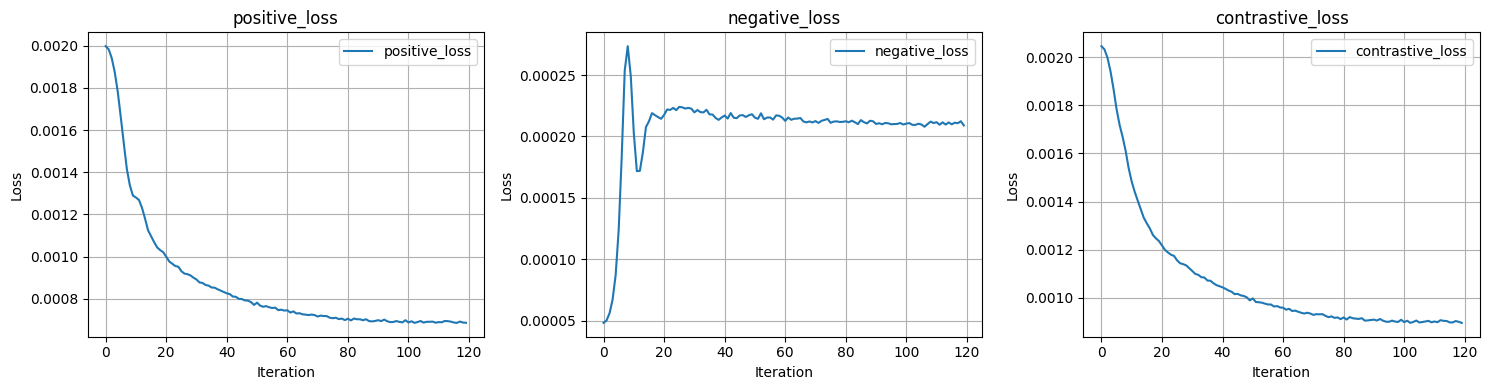

Training Epochs: 100%|██████████| 10/10 [05:38<00:00, 33.85s/it]


In [14]:
from train.train import train_one_epoch, evaluate
import torch
from tqdm import trange

from collections import defaultdict

args.checkpoint_path = "./checkpoint/SAIL"
os.makedirs(args.checkpoint_path, exist_ok=True)

iter_loss_history = defaultdict(list)

for epoch in trange(start_epoch, args.epochs, desc="Training Epochs"):

    train_one_epoch(model, data, loss, epoch, optimizer, scaler, scheduler, args, iter_loss_history)
    completed_epoch = epoch + 1

    if 'val' in data and (args.val_frequency and ((epoch % args.val_frequency) == 0 or epoch == args.epochs)):
        print("evaluate")
        evaluate(model, data, loss, epoch, args)
    # Saving checkpoints.
    if args.sail_model:
        checkpoint_dict = {
            "epoch": completed_epoch,
            "name": args.name,
            "state_dict": model.vlhead.state_dict(),
            "optimizer": optimizer.state_dict(),
        }
    else:
        checkpoint_dict = {
            "epoch": completed_epoch,
            "name": args.name,
            "state_dict": model.state_dict(),
            "optimizer": optimizer.state_dict(),
        }
    if scaler is not None:
        checkpoint_dict["scaler"] = scaler.state_dict()

    if completed_epoch == args.epochs or (
        args.save_frequency > 0 and (completed_epoch % args.save_frequency) == 0
    ):
        torch.save(
            checkpoint_dict,
            os.path.join(args.checkpoint_path, f"epoch_{completed_epoch}.pt"),
        )

In [15]:
from evaluation import coco_eval

args.dataset_root_dir = "/home/dataset"
args.save_dir = "evaluation/backbone_features"

coco_root = os.path.join(args.dataset_root_dir, "coco2017", "val2017")
coco_ann_file = os.path.join(
    args.dataset_root_dir,
    "coco2017",
    "annotations",
    "captions_val2017.json",
)
assert os.path.exists(coco_root), f"COCO root directory does not exist: {coco_root}"
assert os.path.exists(coco_ann_file), f"COCO annotation file does not exist: {coco_ann_file}"

text_model_name = args.text_model.split("/")[-1]
vision_model_name = args.vision_model.split("/")[-1]
model.eval()

results = coco_eval(
    model,
    bs=args.batch_size,
    coco_root=coco_root,
    coco_ann_file=coco_ann_file,
    text_model_name=text_model_name,
    vision_model_name=vision_model_name,
    k_vals=[1, 5, 10],
    save_dir=args.save_dir,
)

loading annotations into memory...
Done (t=0.06s)
creating index...
index created!
Encoding all data...


100%|██████████| 1/1 [00:00<00:00, 10.69it/s]


Text-to-image recall...
Image-to-text recall...
Done.
Text-to-image Recall@K
 R@1: 29.72%
 R@5: 58.17%
 R@10: 70.95%
Image-to-text Recall@K
 R@1: 37.94%
 R@5: 67.50%
 R@10: 78.70%


In [16]:
model

SAILModel(
  (text_model): SentenceEmbedding(
    (model): NewModel(
      (embeddings): NewEmbeddings(
        (word_embeddings): Embedding(30528, 768, padding_idx=0)
        (rotary_emb): NTKScalingRotaryEmbedding()
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): NewEncoder(
        (layer): ModuleList(
          (0-11): 12 x NewLayer(
            (attention): NewSdpaAttention(
              (qkv_proj): Linear(in_features=768, out_features=2304, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
              (o_proj): Linear(in_features=768, out_features=768, bias=True)
            )
            (mlp): NewGatedMLP(
              (up_gate_proj): Linear(in_features=768, out_features=6144, bias=False)
              (down_proj): Linear(in_features=3072, out_features=768, bias=True)
              (act_fn): GELUActivation()
              (hidden_dropout): Dropout(p=0.1, inpl

In [5]:
import torch.nn as nn

custom_Layer = nn.Linear

In [6]:
from model import create_model_custom

CLIP_model = create_model_custom(
    vision_dimesion = data['train'].data_info['visual_dim'],
    text_dimension = data['train'].data_info['text_dim'],
    target_dimension = args.target_dimension,
    precision = args.precision,
    device = device,
    logit_scale = args.logit_scale,
    logit_bias = args.logit_bias,
    custom_Layer = custom_Layer
)

optimizer, scaler = set_optimizer(args, CLIP_model)
scheduler = set_scheduler(optimizer, data, args)
args.siglip = False
loss = create_loss(args)

Using Clip (infoNCE) loss


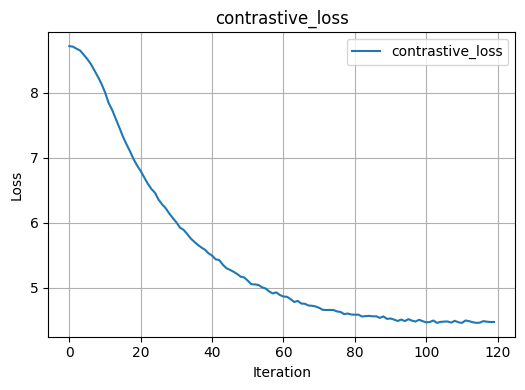

Training Epochs: 100%|██████████| 10/10 [05:32<00:00, 33.25s/it]


In [7]:
from train.train import train_one_epoch, evaluate
import torch
from tqdm import trange

from collections import defaultdict

args.checkpoint_path = "./checkpoint/CLIP"
os.makedirs(args.checkpoint_path, exist_ok=True)

iter_loss_history = defaultdict(list)

for epoch in trange(start_epoch, args.epochs, desc="Training Epochs"):

    train_one_epoch(CLIP_model, data, loss, epoch, optimizer, scaler, scheduler, args, iter_loss_history)
    completed_epoch = epoch + 1

    if 'val' in data and (args.val_frequency and ((epoch % args.val_frequency) == 0 or epoch == args.epochs)):
        print("evaluate")
        evaluate(CLIP_model, data, loss, epoch, args)

    checkpoint_dict = {
        "epoch": completed_epoch,
        "name": args.name,
        "state_dict": CLIP_model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    if scaler is not None:
        checkpoint_dict["scaler"] = scaler.state_dict()

    if completed_epoch == args.epochs or (
        args.save_frequency > 0 and (completed_epoch % args.save_frequency) == 0
    ):
        torch.save(
            checkpoint_dict,
            os.path.join(args.checkpoint_path, f"epoch_{completed_epoch}.pt"),
        )

In [8]:
from eval import main, parse_args

eval_args = [
    "--head-weights-path", "./checkpoint/CLIP/epoch_10.pt",
    "--overwrite",
    "--sail_model",
    "--linear-type", "linear"
    ]
eval_args = parse_args(eval_args)

main(eval_args)


Epoch 10 already exists in COCO, overwriting.
use SAILModel
Using model with SDPA
SAIL AlignmentLayer
linear_type:  FC
vlhead_weights_path ./checkpoint/CLIP/epoch_10.pt
Loaded VL head weights from ./checkpoint/CLIP/epoch_10.pt, <All keys matched successfully>
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Encoding all data...


100%|██████████| 157/157 [00:00<00:00, 1154.09it/s]


Text-to-image recall...
Image-to-text recall...
Done.
Text-to-image Recall@K
 R@1: 10.53%
 R@5: 29.97%
 R@10: 42.99%
Image-to-text Recall@K
 R@1: 14.66%
 R@5: 36.62%
 R@10: 50.18%


In [5]:
import torch.nn as nn
import torch

from typing import Optional

from model import get_cast_dtype

custom_Layer = nn.Linear

class AlignmentLayer_LiT(nn.Module):
    def __init__(
        self,
        vision_dimesion: int,
        text_dimension: int = None,
        target_dimension: int = 1024,
        precision = None,
        logit_scale: float = 10.0,
        logit_bias: float = -10.0,
        custom_Layer = None,
    ):
        super(AlignmentLayer_LiT, self).__init__()

        
        cast_dtype = get_cast_dtype(precision)
        self.cast_dtype = cast_dtype

        LinearLayer = custom_Layer

        self.vision_mapping_network = LinearLayer(
            vision_dimesion, target_dimension
        )
        self.vision_layer_norm = nn.LayerNorm(vision_dimesion)

        self.text_mapping_network = LinearLayer(
            text_dimension, target_dimension
        )
        self.text_layer_norm = nn.LayerNorm(text_dimension)

        self.logit_scale = nn.Parameter(torch.randn(1))
        self.logit_bias = nn.Parameter(torch.randn(1))
        self._initialize_weights(logit_scale, logit_bias)

    def _initialize_weights(self, scale: float, bias: float):

        for module in self.modules():
            if isinstance(module, nn.Linear):
                torch.nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    torch.nn.init.zeros_(module.bias)
            elif isinstance(module, nn.LayerNorm):
                torch.nn.init.ones_(module.weight)
                torch.nn.init.zeros_(module.bias)

        # Initialize logit_scale and logit_bias
        logit_scale_init = torch.log(torch.tensor(scale))                           
        self.logit_scale.data.fill_(logit_scale_init)
        self.logit_bias.data.fill_(torch.tensor(bias))
    
    @property
    def get_logit_scale(self):
        return self.logit_scale.exp()
    
    @property
    def get_logit_bias(self):
        return self.logit_bias
     
    def forward(self, image_features=None, text_features=None, extra_text_features=None, compute_logits=False):

        image_features = image_features.to(self.cast_dtype)
        image_features = self.vision_layer_norm(image_features)
        image_features = self.vision_mapping_network(image_features)

        text_features = text_features.to(self.cast_dtype)
        text_features = self.text_layer_norm(text_features)
        text_features = self.text_mapping_network(text_features)

        return {
            "image_features": image_features,
            "text_features": text_features,
            "extra_text_features": extra_text_features,
            "logit_scale": self.logit_scale.exp(),
            "logit_bias": self.logit_bias
        }

In [6]:
## 정답 코드

import torch.nn as nn
import torch

from typing import Optional

from model import get_cast_dtype

custom_Layer = nn.Linear

class AlignmentLayer_LiT(nn.Module):
    def __init__(
        self,
        vision_dimesion: int,
        text_dimension: int = None,
        target_dimension: int = 1024,
        precision  = None,
        logit_scale: float = 10.0,
        logit_bias: float = -10.0,
        custom_Layer = None,
    ):
        super(AlignmentLayer_LiT, self).__init__()

        cast_dtype = get_cast_dtype(precision)
        self.cast_dtype = cast_dtype

        LinearLayer = custom_Layer

        self.vision_layer_norm = nn.LayerNorm(vision_dimesion)

        target_dimension = vision_dimesion
        self.text_mapping_network = LinearLayer(
            text_dimension, target_dimension
        )
        self.text_layer_norm = nn.LayerNorm(text_dimension)

        self.logit_scale = nn.Parameter(torch.randn(1))
        self.logit_bias = nn.Parameter(torch.randn(1))
        self._initialize_weights(logit_scale, logit_bias)

    def _initialize_weights(self, scale: float, bias: float):

        for module in self.modules():
            if isinstance(module, nn.Linear):
                torch.nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    torch.nn.init.zeros_(module.bias)
            elif isinstance(module, nn.LayerNorm):
                torch.nn.init.ones_(module.weight)
                torch.nn.init.zeros_(module.bias)

        # Initialize logit_scale and logit_bias
        logit_scale_init = torch.log(torch.tensor(scale))                           
        self.logit_scale.data.fill_(logit_scale_init)
        self.logit_bias.data.fill_(torch.tensor(bias))
    
    @property
    def get_logit_scale(self):
        return self.logit_scale.exp()
    
    @property
    def get_logit_bias(self):
        return self.logit_bias
     
    def forward(self, image_features=None, text_features=None, extra_text_features=None, compute_logits=False):

        image_features = image_features.to(self.cast_dtype)
        image_features = self.vision_layer_norm(image_features)

        text_features = text_features.to(self.cast_dtype)
        text_features = self.text_layer_norm(text_features)
        text_features = self.text_mapping_network(text_features)

        return {
            "image_features": image_features,
            "text_features": text_features,
            "extra_text_features": extra_text_features,
            "logit_scale": self.logit_scale.exp(),
            "logit_bias": self.logit_bias
        }

In [7]:
from model import create_model_LiT

alignmentLayer_LiT = AlignmentLayer_LiT(
    vision_dimesion = data['train'].data_info['visual_dim'],
    text_dimension = data['train'].data_info['text_dim'],
    target_dimension = args.target_dimension,
    precision=args.precision,
    logit_scale = args.logit_scale,
    logit_bias = args.logit_bias,
    custom_Layer = custom_Layer
)

LiT_model = create_model_LiT(
    precision = args.precision,
    device = device,
    alignmentLayer = alignmentLayer_LiT
)

optimizer, scaler = set_optimizer(args, LiT_model)
scheduler = set_scheduler(optimizer, data, args)
args.siglip = False
loss = create_loss(args)

Using Clip (infoNCE) loss


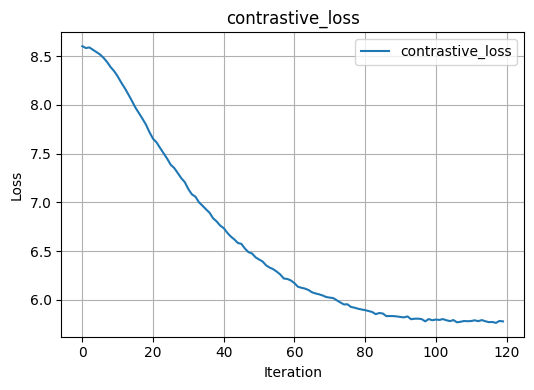

Training Epochs: 100%|██████████| 10/10 [02:54<00:00, 17.46s/it]


In [8]:
from train.train import train_one_epoch, evaluate
import torch
from tqdm import trange

from collections import defaultdict

args.checkpoint_path = "./checkpoint/LiT"
os.makedirs(args.checkpoint_path, exist_ok=True)

iter_loss_history = defaultdict(list)

for epoch in trange(start_epoch, args.epochs, desc="Training Epochs"):

    train_one_epoch(LiT_model, data, loss, epoch, optimizer, scaler, scheduler, args, iter_loss_history)
    completed_epoch = epoch + 1

    if 'val' in data and (args.val_frequency and ((epoch % args.val_frequency) == 0 or epoch == args.epochs)):
        print("evaluate")
        evaluate(LiT_model, data, loss, epoch, args)

    checkpoint_dict = {
        "epoch": completed_epoch,
        "name": args.name,
        "state_dict": LiT_model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    if scaler is not None:
        checkpoint_dict["scaler"] = scaler.state_dict()

    if completed_epoch == args.epochs or (
        args.save_frequency > 0 and (completed_epoch % args.save_frequency) == 0
    ):
        torch.save(
            checkpoint_dict,
            os.path.join(args.checkpoint_path, f"epoch_{completed_epoch}.pt"),
        )

In [9]:
from eval import main, parse_args

eval_args = [
    "--head-weights-path", "./checkpoint/LiT/epoch_10.pt",
    "--overwrite",
    "--sail_model",
    "--linear-type", "linear",
    "--only_text"
    ]
eval_args = parse_args(eval_args)

main(eval_args)


use SAILModel
Using model with SDPA
SAIL AlignmentLayer
only text :  True
linear_type:  FC
vlhead_weights_path ./checkpoint/LiT/epoch_10.pt
Loaded VL head weights from ./checkpoint/LiT/epoch_10.pt, <All keys matched successfully>
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Encoding all data...


100%|██████████| 157/157 [00:00<00:00, 1255.76it/s]


Text-to-image recall...
Image-to-text recall...
Done.
Text-to-image Recall@K
 R@1: 3.75%
 R@5: 12.98%
 R@10: 21.04%
Image-to-text Recall@K
 R@1: 5.88%
 R@5: 18.94%
 R@10: 27.78%


In [ ]:

import torch.nn as nn

class ShareLockMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_prob=0.2):
        super(ShareLockMLP, self).__init__()
        
        # Define the layers
        self.layers = nn.Linear(input_dim, hidden_dim)

    def forward(self, x):
        return self.layers(x)

custom_Layer = ShareLockMLP

In [ ]:
## 정답 코드

import torch.nn as nn

class ShareLockMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_prob=0.2):
        super(ShareLockMLP, self).__init__()
        
        # Define the layers
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.layers(x)

custom_Layer = ShareLockMLP

In [9]:
from model import create_model_ShareLock

ShareLock_model = create_model_ShareLock(
    vision_dimesion = data['train'].data_info['visual_dim'],
    text_dimension = data['train'].data_info['text_dim'],
    target_dimension = args.target_dimension,
    precision = args.precision,
    device = device,
    logit_scale = args.logit_scale,
    logit_bias = args.logit_bias,
    custom_Layer = custom_Layer
)

optimizer, scaler = set_optimizer(args, ShareLock_model)
scheduler = set_scheduler(optimizer, data, args)
args.siglip = False
loss = create_loss(args)

Using Clip (infoNCE) loss


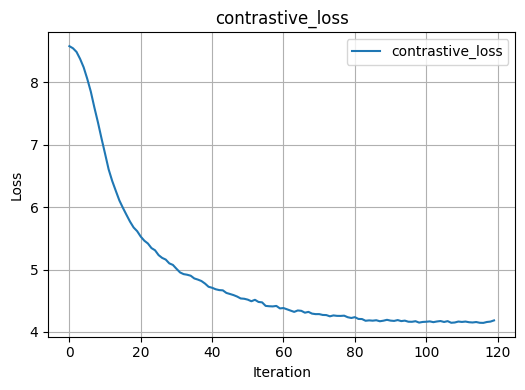

Training Epochs: 100%|██████████| 10/10 [03:59<00:00, 23.98s/it]


In [10]:
from train.train import train_one_epoch, evaluate
import torch
from tqdm import trange

from collections import defaultdict

args.checkpoint_path = "./checkpoint/ShareLock"
os.makedirs(args.checkpoint_path, exist_ok=True)

iter_loss_history = defaultdict(list)

for epoch in trange(start_epoch, args.epochs, desc="Training Epochs"):

    train_one_epoch(ShareLock_model, data, loss, epoch, optimizer, scaler, scheduler, args, iter_loss_history)
    completed_epoch = epoch + 1

    if 'val' in data and (args.val_frequency and ((epoch % args.val_frequency) == 0 or epoch == args.epochs)):
        print("evaluate")
        evaluate(ShareLock_model, data, loss, epoch, args)

    checkpoint_dict = {
        "epoch": completed_epoch,
        "name": args.name,
        "state_dict": ShareLock_model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    if scaler is not None:
        checkpoint_dict["scaler"] = scaler.state_dict()

    if completed_epoch == args.epochs or (
        args.save_frequency > 0 and (completed_epoch % args.save_frequency) == 0
    ):
        torch.save(
            checkpoint_dict,
            os.path.join(args.checkpoint_path, f"epoch_{completed_epoch}.pt"),
        )

In [11]:
from eval import main, parse_args

eval_args = [
    "--head-weights-path", "./checkpoint/ShareLock/epoch_10.pt",
    "--overwrite",
    "--sail_model",
    "--linear-type", "linear",
    "--sharelock"
    ]
eval_args = parse_args(eval_args)

main(eval_args)


use SAILModel
use sharelock
Using model with SDPA
SAIL sharelock
vlhead_weights_path ./checkpoint/ShareLock/epoch_10.pt
Loaded VL head weights from ./checkpoint/ShareLock/epoch_10.pt, <All keys matched successfully>
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Encoding all data...


100%|██████████| 157/157 [00:00<00:00, 1159.99it/s]


Text-to-image recall...
Image-to-text recall...
Done.
Text-to-image Recall@K
 R@1: 14.56%
 R@5: 38.27%
 R@10: 52.66%
Image-to-text Recall@K
 R@1: 32.64%
 R@5: 59.98%
 R@10: 72.00%


In [7]:
# args = [
#     "--batch-size", "5000",
#     "--lr", "1e-5",
#     "--epochs", "10",
#     "--target-dimension", "1024"
# ]